# ECE 1513: Project Source Code (Team 23)

---

**Enhancing Text Classification: A Comparative Study of CNN, SVM, and RNN Models**

Chen Wang (1005281446),
Pas Panthasen (1009776654),
Yan Pan Chung (1007598039),
Sebastian Tampu (1004928572)

Note: datasets and saved models will be downloaded while running this code

# Setup and Imports

In [1]:
#likely uninstalled library
%pip install contractions

In [2]:
import os
import re
import urllib.request
import zipfile
from joblib import dump, load

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, PorterStemmer

import contractions
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from IPython.display import clear_output

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

pd.set_option('display.max_colwidth', None)

clear_output()

In [3]:
# Download datasets
if not os.path.exists('dataset'):
    url='https://drive.google.com/uc?export=download&id=1188xRkwQe8k_tK0ro4yvBsNqIxGvQzBL'
    urllib.request.urlretrieve(url, 'dataset.zip')
    with zipfile.ZipFile('dataset.zip', 'r') as zip_ref:
        zip_ref.extractall('dataset')

### Dataset References

1. Banking77 - [https://huggingface.co/datasets/banking77](https://huggingface.co/datasets/banking77)
2. 10 Newsgroup - [https://www.kaggle.com/datasets/jensenbaxter/10dataset-text-document-classification](https://www.kaggle.com/datasets/jensenbaxter/10dataset-text-document-classification)
3. AG's News - [https://huggingface.co/datasets/ag_news](https://huggingface.co/datasets/ag_news)


# Preprocessing

In [4]:
datasets = ['banking77', 'ag_news', '10newsgroup']

In [5]:
def load_dataset(name, folder_path='dataset', shuffle=True, frac=1):
    try:
        train_dataset = pd.read_parquet(os.path.join(folder_path, name+'_train.parquet'))
        test_dataset = pd.read_parquet(os.path.join(folder_path, name+'_test.parquet'))
    except FileNotFoundError:
        dataset = pd.read_parquet(os.path.join(folder_path, name+'.parquet'))
        train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, stratify=dataset['label'], random_state=42)
    if not np.issubdtype(train_dataset['label'].dtype, np.integer):
        label_encoder = LabelEncoder()
        train_dataset['label'] = label_encoder.fit_transform(train_dataset['label'])
        test_dataset['label'] = label_encoder.transform(test_dataset['label'])
    if frac!=1:
        train_dataset = train_dataset.groupby('label').apply(lambda x: x.sample(frac=frac)).reset_index(drop=True)
    if shuffle:
        train_dataset = train_dataset.sample(frac=1, random_state=42)
    return train_dataset, test_dataset

In [6]:
# computes statistics for each dataset
stats = np.zeros((len(datasets), 4))
for i, data in enumerate(datasets):
    df = pd.concat(load_dataset(data), ignore_index=True)
    stats[i] = [len(df), len(df.label.unique()), np.max(df.text.apply(len)), np.mean(df.text.apply(len))]
columns = ['Size', '#Classes', 'Max txt length', 'Avg txt length']
df_stats = pd.DataFrame(stats.round(0), columns=columns, index=datasets).astype(int)
print(df_stats)

               Size  #Classes  Max txt length  Avg txt length
banking77     13083        77             433              58
ag_news      127600         4            1012             236
10newsgroup    1000        10           55227            2574


In [7]:
def preprocess_text(text, opt=3):
    if opt==1:
        # Tokenize the text
        tokens = word_tokenize(text)
        
        # Convert tokens to lowercase
        tokens = [token.lower() for token in tokens]

        # Remove tokens that are mixed between alphabets and numbers
        tokens = [token for token in tokens if token.isalpha()]
    else:
        # Replace email addresses with an empty string
        email_pattern = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
        text = re.sub(email_pattern, '', text)
        
        # Expand contractions
        text = ' '.join([contractions.fix(word) for word in text.split()])
        
        # Replace non-alphanumeric characters with space
        text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
        
        # Replace multiple spaces with a single space
        text = re.sub(r'\s+', ' ', text)    

        # Tokenize the text
        tokens = word_tokenize(text)

        # Convert tokens to lowercase
        tokens = [token.lower() for token in tokens]
        
        # Remove tokens that are mixed between alphabets and numbers
        tokens = [token for token in tokens if token.isalpha()]

        # Remove stopwords
        if opt==3:
            stop_words = set(stopwords.words('english'))
            tokens = [token for token in tokens if not token in stop_words]

        # Perform POS tagging
        pos_tags = nltk.pos_tag(tokens)

        # Define a function to convert NLTK POS tags to WordNet POS tags
        def get_wordnet_pos(treebank_tag):
            if treebank_tag.startswith('J'):
                return wordnet.ADJ
            elif treebank_tag.startswith('V'):
                return wordnet.VERB
            elif treebank_tag.startswith('N'):
                return wordnet.NOUN
            elif treebank_tag.startswith('R'):
                return wordnet.ADV
            else:
                return None  # Return None if the tag is not recognized

        # Initialize lemmatizer
        lemmatizer = WordNetLemmatizer()

        # Lemmatization with POS tags
        tokens = []
        for token, pos_tag in pos_tags:
            wordnet_pos = get_wordnet_pos(pos_tag)
            if wordnet_pos is not None:
                lemma = lemmatizer.lemmatize(token, pos=wordnet_pos)
            else:
                lemma = lemmatizer.lemmatize(token)
            tokens.append(lemma)
        
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(token) if len(token) > 6 else token for token in tokens]

    return " ".join(tokens)

In [8]:
dict_words = {}
# Encode text using a word dict when words appear >3 times and pad sequences to a fixed length of max #words in one text data
def encode_text(train_dataset, test_dataset, min_word_freq=3):
    global dict_words, maxlen
    
    word_counts = Counter(word for text in train_dataset.text for word in text.split())
    frequent_words = [word for word, count in word_counts.items() if count > min_word_freq]
    vocab_list = [''] + frequent_words
    
    dict_words = {word: idx for idx, word in enumerate(vocab_list)}
    maxlen = max(train_dataset.text.str.split().apply(len))

    def pad_sequences(data):
        data = data.apply(lambda x: [dict_words.get(word, 0) for word in x.split() if word in frequent_words])
        return keras.preprocessing.sequence.pad_sequences(data, maxlen=maxlen)

    text_vec_train = pad_sequences(train_dataset.text)
    text_vec_test = pad_sequences(test_dataset.text)
    
    return text_vec_train, text_vec_test

class CustomDataset(Dataset):
    def __init__(self, text,label):
        self.text = text
        self.labels = label

    def __len__(self):
        return len(self.text)

    def __getitem__(self, idx):
        text = self.text[idx]
        label = self.labels[idx]
        sample = {"Text": torch.tensor(text, dtype=torch.long),
                  "label": torch.tensor(label, dtype=torch.long)}
        return sample

# Make text data suitable for input of CNN
def preprocessCNN(train_dataset, test_dataset, batch_size=32, min_word_freq=3):
    global text_vec_train, text_vec_test
    text_vec_train, text_vec_test = encode_text(train_dataset, test_dataset, min_word_freq)
    
    X_train, X_valid, y_train, y_valid = train_test_split(text_vec_train, train_dataset.label, test_size=0.25, random_state=42)
    X_test, y_test = text_vec_test, test_dataset.label
    
    n_labels = len(train_dataset.label.unique())

    y_train = tf.one_hot(y_train, depth=n_labels).numpy()
    y_valid = tf.one_hot(y_valid, depth=n_labels).numpy()
    y_test = tf.one_hot(y_test, depth=n_labels).numpy()
    
    train_dataset=CustomDataset(X_train,y_train)
    valid_dataset=CustomDataset(X_valid,y_valid)
    test_dataset=CustomDataset(X_test,y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)    
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, valid_loader, test_loader

In [9]:
train_dataset, test_dataset = load_dataset(datasets[0])
train_dataset['ProcTxt'] = train_dataset.text.apply(lambda x: preprocess_text(x, opt=2))
test_dataset['ProcTxt'] = test_dataset.text.apply(lambda x: preprocess_text(x, opt=2))

In [10]:
# example of processed text
train_dataset.head()

,text,label,ProcTxt
6883,Is it possible for me to change my PIN number?,21,be it possibl for me to change my pin number
5836,I'm not sure why my card didn't work,25,i be not sure why my card do not work
8601,I don't think my top up worked,59,i do not think my top up work
2545,Can you explain why my payment was charged a fee?,15,can you explain why my payment be charge a fee
8697,"How long does a transfer from a UK account take? I just made one and it doesn't seem to be working, wondering if everything is okay",5,how long do a transfer from a uk account take i just make one and it do not seem to be work wonder if everyth be okay


# Model Building and Training

## Support Vector Machine (SVM)

In [11]:
class SVM:
    def __init__(self, train_dataset, kernels=['linear', 'poly', 'rbf', 'sigmoid'], c_vals=[0.1, 1, 10], gamma_vals=[0.01, 0.1, 1]):
        self.kernels = kernels
        self.c_vals = c_vals
        self.gamma_vals = gamma_vals
        self.best_scores = None
        self.best_params = None
        self.best_model = None
        self.clf = None
        self.tfidf_vectorizer = TfidfVectorizer(max_features=10000)
        
        self.X_train_tfidf = self.tfidf_vectorizer.fit_transform(train_dataset['text'])
        self.y_train = train_dataset['label']

    def train(self):
        # Create hyperparameters dictionary
        hyperparameters = {
            kernel: [{'C': C, 'gamma': gamma} for C in self.c_vals for gamma in self.gamma_vals] if kernel != 'linear' else [{'C': C} for C in self.c_vals] for kernel in self.kernels
        }

        self.best_scores = []
        self.best_params = []

        # for one set of hyperparmater
        if len(self.kernels) == len(self.c_vals) == len(self.gamma_vals) == 1:
            for kernel, params in hyperparameters.items():
                for param_set in params:
                    self.clf = SVC(kernel=self.kernels[0], **param_set).fit(self.X_train_tfidf, self.y_train)
        
        # for fine tune
        else:
            for kernel, params in hyperparameters.items():
                best_score = 0
                best_param = None
                for param_set in params:
                    clf = SVC(kernel=kernel, **param_set)
                    scores = cross_val_score(clf, self.X_train_tfidf, self.y_train, cv=2)
                    mean_score = np.mean(scores)

                    if mean_score > best_score:
                        best_score = mean_score
                        best_param = param_set

                self.best_scores.append(best_score)
                self.best_params.append(best_param)
                print(f"Best Score for {kernel}: {best_score:.4f}, Params: {best_param}")

            # Select best model based on cross-validation scores
            self.best_model = np.argmax(self.best_scores)

            self.clf = SVC(kernel=self.kernels[self.best_model], **self.best_params[self.best_model]).fit(self.X_train_tfidf, self.y_train)

    def test(self, test_dataset):
        X_test_tfidf = self.tfidf_vectorizer.transform(test_dataset['text'])
        y_test = test_dataset['label']

        test_accuracy = accuracy_score(y_test, self.clf.predict(X_test_tfidf))
        
        if self.best_model is not None:
            print(f"Test Accuracy: {test_accuracy:.4f} when using {self.kernels[self.best_model]} kernel with",
              ", ".join([f"{key}: {value}" for key, value in self.best_params[self.best_model].items()]))

        return test_accuracy

In [12]:
# example SVM usage
svm = SVM(train_dataset)
svm.train()
acc = svm.test(test_dataset)

Best Score for linear: 0.8650, Params: {'C': 1}
Best Score for poly: 0.7845, Params: {'C': 10, 'gamma': 1}
Best Score for rbf: 0.8687, Params: {'C': 10, 'gamma': 0.1}
Best Score for sigmoid: 0.8651, Params: {'C': 10, 'gamma': 0.1}
Test Accuracy: 0.9039 when using rbf kernel with C: 10, gamma: 0.1


## CNN

In [13]:
train_dataset, test_dataset = load_dataset('ag_news', frac=5000/120000)
train_loader, valid_loader, test_loader = preprocessCNN(train_dataset, test_dataset)

In [14]:
params = {
    'num_kernels': 100,
    'kernel_size': [2, 3, 4],
    'num_class': len(train_dataset.label.unique()),
    'stride': 1,
    'pretrained_weight': False,
    #input size
    'vocab_size': len(dict_words),
    'embedding_dim': 300,
    'dropout': 0.5
}

In [15]:
class CNNClassifier(nn.Module):
    def __init__(self, params):
        super(CNNClassifier, self).__init__()

        self.num_kernels = params["num_kernels"]
        self.kernel_size = params["kernel_size"]
        self.num_class = params["num_class"]
        self.stride = params["stride"]

        if params["pretrained_weight"]:
            word_model_emb = np.load(params["pretrained_weight_path"])
            weights = torch.tensor(word_model_emb)
            self.emb = nn.Embedding.from_pretrained(weights)
        else:
            self.emb = nn.Embedding(params["vocab_size"], params["embedding_dim"])
            
        self.conv_0 = nn.Conv2d(1, self.num_kernels, (self.kernel_size[0], params["embedding_dim"]), self.stride)
        self.conv_1 = nn.Conv2d(1, self.num_kernels, (self.kernel_size[1], params["embedding_dim"]), self.stride)
        self.conv_2 = nn.Conv2d(1, self.num_kernels, (self.kernel_size[2], params["embedding_dim"]), self.stride)

        # conv output size: [(w-k)+2p]/s+1
        # (batch, channel=1, seq_len, emb_size)
        self.fc = nn.Linear(len(self.kernel_size) * self.num_kernels, self.num_class)
        self.dropout = nn.Dropout(params["dropout"])
        
    def forward(self, text):
        emb = self.emb(text)  # (batch, maxlen, emb_size)
        emb = emb.unsqueeze(dim=1)  # (batch, channel=1, maxlen, emb_size)

        # after conv: (batch, num_kernels, seq_len - kernel_size[0] + 1, 1)
        conved0 = F.relu(self.conv_0(emb).squeeze(3))
        conved1 = F.relu(self.conv_1(emb).squeeze(3))
        conved2 = F.relu(self.conv_2(emb).squeeze(3))

        # pooled: (batch, n_channel)
        pool0 = nn.MaxPool1d(conved0.shape[2], self.stride)
        pool1 = nn.MaxPool1d(conved1.shape[2], self.stride)
        pool2 = nn.MaxPool1d(conved2.shape[2], self.stride)

        pooled0 = pool0(conved0).squeeze(2)
        pooled1 = pool1(conved1).squeeze(2)
        pooled2 = pool2(conved2).squeeze(2)

        # (batch, n_chanel * num_filters)
        cat_pool = torch.cat([pooled0, pooled1, pooled2], dim=1)
        fc = self.fc(cat_pool)
        
        return fc

In [16]:
def get_accuracy(model, data):
    """ Compute the accuracy of the `model` across a dataset `data` """
    # Ensure model is in evaluation mode, which turns off dropout
    model.eval()

    # Variables to track total and correct predictions
    correct = 0
    total = 0

    # Disable gradient calculations for efficiency
    with torch.no_grad():
        for batch in data:
            # Get input data and labels
            inputs, labels = batch['Text'], batch['label']
            labels = np.argmax(labels,axis=1)

            # Move data to the same device as the model
            if torch.cuda.is_available():
                inputs, labels = inputs.cuda(), labels.cuda()

            # Forward pass to get outputs
            outputs = model(inputs)

            # Convert output probabilities to predicted class (0 or 1)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1) 
            
            # Count total and correct predictions
            total += labels.size(0)
            correct += (preds.squeeze() == labels).sum().item()

    # Calculate accuracy
    accuracy = correct / total
    return accuracy

In [17]:
#Training
model = CNNClassifier(params)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def train_cnn(num_epochs=200,  val_interval=5, early_stop_patience=5, best_model_path='best_model_path.pth', lr=0.001):
    global model
    best_val_acc = -float('inf')
    patience_count = 0
    
    # Define the loss function
    criterion = nn.CrossEntropyLoss()

    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    for epoch in range(num_epochs):
        train_loss = 0.0
        model.train()  # Set the model to training mode
        for batch in train_loader:
            inputs, labels = batch['Text'].to(device), batch['label'].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.float(), labels.float())
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

        # Calculate average training loss for the epoch
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Calculate training accuracy for the epoch
        train_accuracy = get_accuracy(model, train_loader)
        train_accuracies.append(train_accuracy)

        # Validation
        if epoch % val_interval == 0 or epoch == num_epochs - 1:
            val_loss = 0.0
            model.eval()  # Set the model to evaluation mode
            with torch.no_grad():
                for batch in valid_loader:
                    inputs, labels = batch['Text'].to(device), batch['label'].to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs.float(), labels.float())
                    val_loss += loss.item() * inputs.size(0)

            # Calculate average validation loss for the epoch
            val_loss /= len(valid_loader.dataset)
            val_losses.append(val_loss)

            # Calculate validation accuracy for the epoch
            val_accuracy = get_accuracy(model, valid_loader)
            val_accuracies.append(val_accuracy)

            # Print epoch summary
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")
            # Check for early stopping
            if val_accuracy > best_val_acc:
                best_val_acc = val_accuracy
                patience_count = 0
                torch.save(model.state_dict(), best_model_path)
            else:
                patience_count += 1
                if patience_count >= early_stop_patience:
                    print("Early stopping triggered.")
                    break  # Exit training loop
    model.load_state_dict(torch.load(best_model_path))

In [18]:
def test_cnn():
    # Set the model to evaluation mode
    model.eval()

    # Initialize lists to store true labels and predicted labels
    true_labels = []
    predicted_labels = []

    # Disable gradient calculation
    with torch.no_grad():
        for batch in test_loader:
            inputs, labels = batch['Text'].to(device), batch['label'].to(device)
            # convert labels back from one_hot_encoder
            labels = torch.argmax(labels, dim=1)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # Get class predictions by taking the index of the maximum value
            true_labels.extend(labels.tolist())  # Convert labels tensor to list and extend the true_labels list
            predicted_labels.extend(preds.tolist())  # Convert predicted labels tensor to list and extend the predicted_labels list

    # Compute evaluation metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    print("Accuracy:", round(accuracy,4))
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    return accuracy

### Hyperpameter Tuning

In [19]:
# Iterate over hyperparameters using itertools.product
from itertools import product
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
param_grid = {
    'lr': [0.001, 0.01],
    'kernel_size': [[2, 3, 4], [3, 4, 5]],
    'dropout': [0.2, 0.5, 0.6]
}
def Hyper_cnn(train_loader, valid_loader, num_epochs=20,  val_interval=1, early_stop_patience=5,checkpoint_dir='checkpoints'):
    global model

    all_train_losses, all_val_losses = [], []
    all_train_accuracies, all_val_accuracies = [], []
    os.makedirs(checkpoint_dir, exist_ok=True)  # Create checkpoint directory if it doesn't exist
    results = []

    for lr, kernel_size, dropout_rate in product(param_grid['lr'], param_grid['kernel_size'], param_grid['dropout']):
        print(f"Start Training on hyperparamters:lr={lr}, kernel_size={kernel_size}, dropout_rate={dropout_rate}")
        # Define model and optimizer
        best_val_accuracy = 0
        patience_count = 0
        params = {
            'num_kernels': 100,
            'kernel_size': kernel_size,
            'num_class': len(train_dataset.label.unique()),
            'stride': 1,
            'pretrained_weight': False,
            #input size
            'vocab_size': len(dict_words),
            'embedding_dim': 300,
            'dropout': dropout_rate
        }
        model = CNNClassifier(params).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_lr{lr}__kernel{kernel_size}_dropout{dropout_rate}.pth')                    
        # Train the model
        train_losses, val_losses = [], []
        train_accuracies, val_accuracies = [], []
        for epoch in range(num_epochs):
            train_loss = 0.0
            model.train()  # Set the model to training mode
            for batch in train_loader:
                inputs, labels = batch['Text'].to(device), batch['label'].to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs.float(), labels.float())
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * inputs.size(0)

            # Calculate average training loss for the epoch
            train_loss /= len(train_loader.dataset)
            train_losses.append(train_loss)

            # Calculate training accuracy for the epoch
            train_accuracy = get_accuracy(model, train_loader)
            train_accuracies.append(train_accuracy)

            # Validation
            if epoch % val_interval == 0 or epoch == num_epochs - 1:
                val_loss = 0.0
                model.eval()  # Set the model to evaluation mode
                with torch.no_grad():
                    for batch in valid_loader:
                        inputs, labels = batch['Text'].to(device), batch['label'].to(device)
                        outputs = model(inputs)
                        loss = criterion(outputs.float(), labels.float())
                        val_loss += loss.item() * inputs.size(0)

                # Calculate average validation loss for the epoch
                val_loss /= len(valid_loader.dataset)
                val_losses.append(val_loss)

                # Calculate validation accuracy for the epoch
                val_accuracy = get_accuracy(model, valid_loader)
                val_accuracies.append(val_accuracy)

                # Print epoch summary
                print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")
                # Check for early stopping
                checkpoint = {
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'val_loss': val_loss,
                        'val_accuracy': val_accuracy,
                        'train_losses': train_losses,
                        'val_losses': val_losses
                    }
                torch.save(checkpoint, checkpoint_path)
                
                if val_accuracy > best_val_accuracy:
                    best_val_accuracy = val_accuracy
                    patience_count = 0

                else:
                    patience_count += 1
                    if patience_count >= early_stop_patience:
                        print("Early stopping triggered.")
                        break  # Exit training loop
                    
        results.append({'lr': lr, 'kernel_size': kernel_size, 'dropout_rate': dropout_rate, 'val_accuracy': val_accuracy})
        results_df = pd.DataFrame(results)
        all_train_losses.append(train_losses)
        all_val_losses.append(val_losses)
        all_train_accuracies.append(train_accuracies)
        all_val_accuracies.append(val_accuracies)
    clear_output()
    print(results_df)
    # Plot training and validation curves for all combinations
    plt.figure(figsize=(10, 5))
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'tab:orange', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:olive']

    for i, (train_losses, val_losses) in enumerate(zip(all_train_losses, all_val_losses)):
        color = colors[i % len(colors)]
        plt.plot(range(1, len(train_losses) + 1), train_losses, label=f"Train lr={lr}, kernel_size={kernel_size}, dropout_rate={dropout_rate}", color=color)
        plt.plot(range(1, len(val_losses) + 1), val_losses, label=f"Valid lr={lr}, kernel_size={kernel_size}, dropout_rate={dropout_rate}", color=color, linestyle='--')


    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.xlim(0.5,21.5)
    plt.xticks(range(1,22,2))
    plt.legend(loc='best', fontsize=5)
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 5))
    for i, (train_accuracies, val_accuracies) in enumerate(zip(all_train_accuracies, all_val_accuracies)):
        color = colors[i % len(colors)]
        plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label=f"Train lr={lr}, kernel_size={kernel_size}, dropout_rate={dropout_rate}", color=color)
        plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label=f"Valid lr={lr}, kernel_size={kernel_size}, dropout_rate={dropout_rate}", color=color)


    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlim(0.5,21.5)
    plt.xticks(range(1,22,2))
    plt.legend(loc='best', fontsize=5)
    plt.grid(True)
    plt.show()

    return all_train_losses,all_val_losses,all_train_accuracies,all_val_accuracies

       lr kernel_size  dropout_rate  val_accuracy
0   0.001   [2, 3, 4]           0.2        0.7928
1   0.001   [2, 3, 4]           0.5        0.8024
2   0.001   [2, 3, 4]           0.6        0.7856
3   0.001   [3, 4, 5]           0.2        0.7728
4   0.001   [3, 4, 5]           0.5        0.7768
5   0.001   [3, 4, 5]           0.6        0.7904
6   0.010   [2, 3, 4]           0.2        0.7960
7   0.010   [2, 3, 4]           0.5        0.7336
8   0.010   [2, 3, 4]           0.6        0.8016
9   0.010   [3, 4, 5]           0.2        0.7632
10  0.010   [3, 4, 5]           0.5        0.7664
11  0.010   [3, 4, 5]           0.6        0.7760


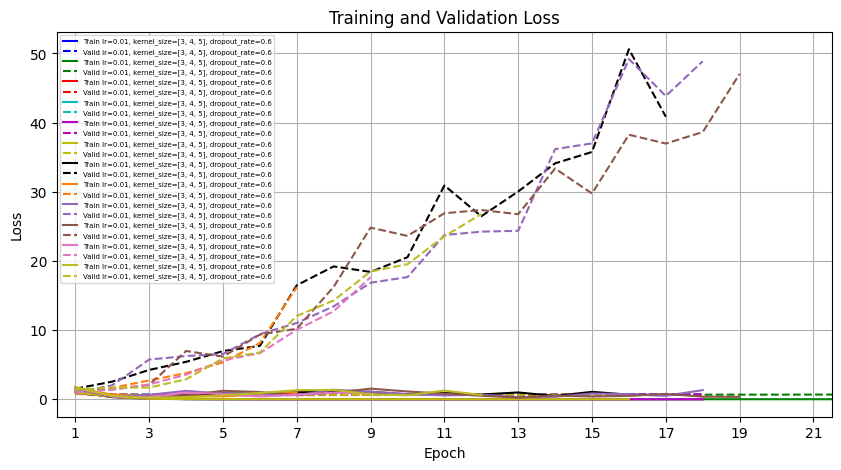

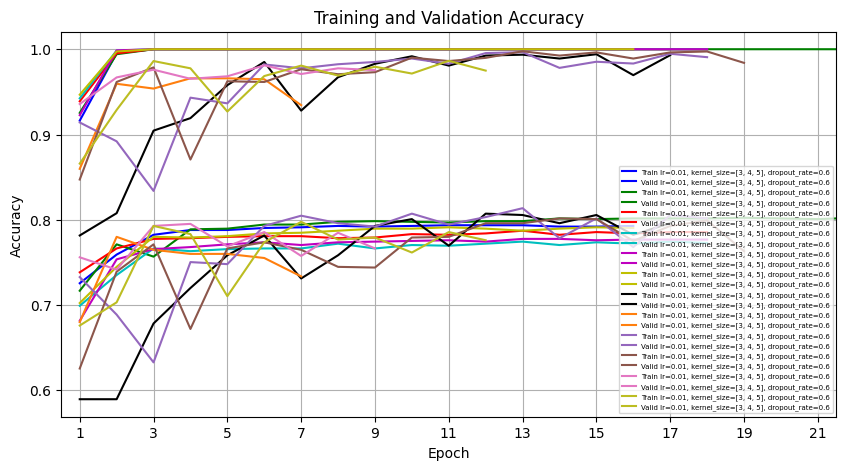

In [20]:
cnn_stats = Hyper_cnn(train_loader,valid_loader,num_epochs=200)

## RNN

In [21]:
train_dataset, test_dataset = load_dataset('banking77')
train_dataset['text'] = train_dataset.text.apply(lambda x: preprocess_text(x, opt=1))
test_dataset['text'] = test_dataset.text.apply(lambda x: preprocess_text(x, opt=1))

In [22]:
def init_rnn(save_path='best_model.h5', min_word_freq=3, skip_encode=False):
    global text_vec_train, text_vec_test, model, checkpoint, early_stopping
    if not skip_encode:
        text_vec_train, text_vec_test = encode_text(train_dataset, test_dataset, min_word_freq)
    
    model = keras.Sequential()

    model.add(layers.Embedding(len(dict_words), 40, input_length=maxlen, name='layer_input'))
    model.add(layers.Bidirectional(layers.LSTM(128, dropout=0.5), name='layer_BiLSTM'))
    model.add(layers.Dense(len(train_dataset.label.unique()), activation='softmax', name='layer_output'))

    model.summary()
    
    model.compile(optimizer = keras.optimizers.Adam(learning_rate=5e-3),
              loss = keras.losses.SparseCategoricalCrossentropy(),
              metrics = ['acc']) 
    
    checkpoint = ModelCheckpoint(save_path, 
                             monitor='val_acc', 
                             save_best_only=True, 
                             mode='max', 
                             verbose=1)
    early_stopping = EarlyStopping(monitor='val_acc', patience=5, restore_best_weights=True)


In [23]:
init_rnn()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_input (Embedding)     (None, 77, 40)            41440     
                                                                 
 layer_BiLSTM (Bidirectiona  (None, 256)               173056    
 l)                                                              
                                                                 
 layer_output (Dense)        (None, 77)                19789     
                                                                 
Total params: 234285 (915.18 KB)
Trainable params: 234285 (915.18 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
result = model.fit(text_vec_train, train_dataset.label, 
                epochs=20, 
                batch_size=32,
                validation_split=0.15,
                callbacks=[checkpoint, early_stopping])
clear_output()

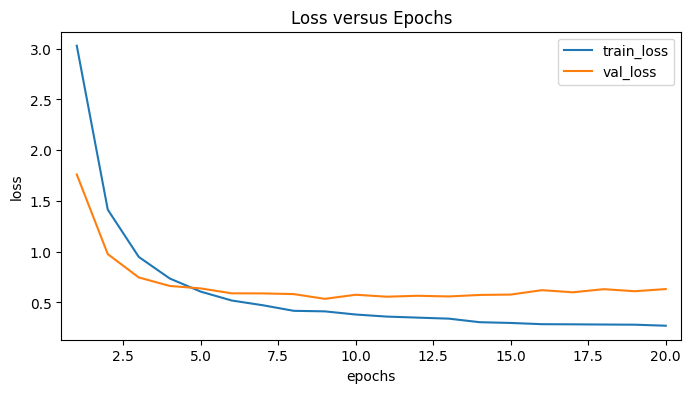

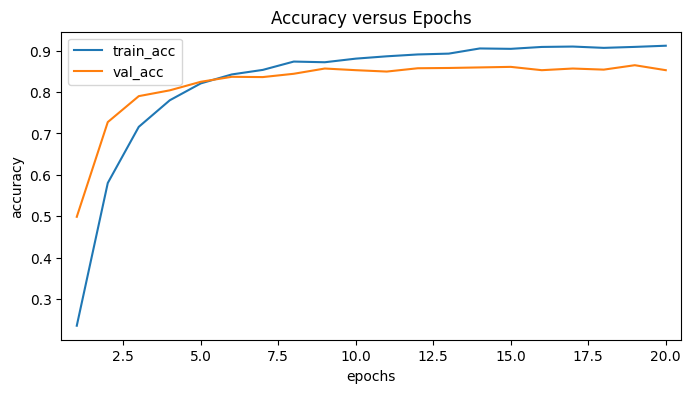

In [25]:
epochs = range(1, result.epoch[-1]+2)
train_loss = result.history.get('loss')  
train_acc = result.history.get('acc')  
val_loss = result.history.get('val_loss')  
val_acc = result.history.get('val_acc')  
 
plt.figure(figsize=(8, 4))
plt.plot(epochs, train_loss, label='train_loss')  
plt.plot(epochs, val_loss, label='val_loss') 
plt.legend()  
plt.title('Loss versus Epochs')
plt.xlim(0.5,result.epoch[-1]+1.5)
plt.xlabel('epochs')
plt.ylabel('loss')
 
plt.figure(figsize=(8, 4))
plt.plot(epochs, train_acc, label='train_acc')  
plt.plot(epochs, val_acc, label='val_acc')
plt.xlim(0.5,result.epoch[-1]+1.5)  
plt.legend()
plt.title('Accuracy versus Epochs')
plt.xlabel('epochs')
plt.ylabel('accuracy')

plt.show()

In [26]:
def test_rnn(save_path='best_model.h5'):
    best_model = keras.models.load_model(save_path)
    _, acc_test_best = best_model.evaluate(text_vec_test, test_dataset.label)
    return acc_test_best

In [27]:
test_acc = test_rnn()

97/97 [==============================] - 2s 16ms/step - loss: 0.5462 - acc: 0.8649


### Hyperparameter Tuning

In [28]:
# partial load the dataset for faster run, using frac=1 for full run
train_dataset, test_dataset = load_dataset('banking77', frac=0.02)

# comment this out for full run
# train_dataset, test_dataset = load_dataset('banking77')

train_dataset['text'] = train_dataset.text.apply(lambda x: preprocess_text(x, opt=1))
test_dataset['text'] = test_dataset.text.apply(lambda x: preprocess_text(x, opt=1))

init_rnn()
clear_output()

In [29]:
best_model_path = 'best_model.h5'
# hyperparameters applied to BiLSTM model and training process
# for banking77 dataset
batch_size = 16
valid_split = 0.15
em_dim = 70
learning_rate = 5e-3
num_hidden_layers = 128
epochs = 20
dropout = 0.5
b1 = 0.9; b2 = 0.999

# for ag_news dataset
# batch_size = 200
# valid_split = 0.1
# em_dim = 100
# learning_rate = 5e-3
# num_hidden_layers = 64
# epochs = 5
# dropout = 0.5
# b1 = 0.5; b2 = 0.5

num_words = len(dict_words)
num_outputs = len(train_dataset.label.unique())

labels_train = train_dataset.label
labels_test = test_dataset.label

In [30]:
def BiLSTM(num_words, em_dim, maxlen, num_hidden_layers, dropout, num_outputs):
    # create a BiLSTM model with defined hyperparameters
    model = keras.Sequential(name='BiLSTM')
    model.add(layers.Embedding(num_words, em_dim, input_shape=(maxlen,), name='layer_input'))
    model.add(layers.Bidirectional(layers.LSTM(num_hidden_layers, dropout=dropout), name='layer_BiLSTM'))
    model.add(layers.Dense(num_outputs, activation='softmax', name='layer_output'))
    
    return model 

In [31]:
def train(model, testdata, testlabels, data, labels, rate, epochs, bs, split, b1, b2):
    # compile the model with an Adam optimizer and a crossentropy loss function
    model.compile(optimizer = keras.optimizers.Adam(learning_rate=rate,
                                                    beta_1=b1, beta_2=b2),
                  loss = keras.losses.SparseCategoricalCrossentropy(), metrics = ['acc']) 

    # use a callback function to monitor the accuracy of validation 
    # and store the best model with the highest accuracy of validation
    checkpoint = ModelCheckpoint(best_model_path, monitor='val_acc', 
                                 save_best_only=True, mode='max', verbose=0)

    # train the model with preprocessed data and hyperparameters
    result = model.fit(data, labels, epochs=epochs, batch_size=bs, verbose=0,
                       validation_split=split, callbacks=[checkpoint])

    # record loss and accuracy of training and validation
    loss_train = result.history.get('loss')  
    acc_train = result.history.get('acc')  
    loss_val = result.history.get('val_loss')  
    acc_val = result.history.get('val_acc')  

    # evaluate loss and accuracy of the model with testing set
    loss_test, acc_test = model.evaluate(testdata, testlabels, verbose=0)
    
    return loss_train, acc_train, loss_val, acc_val, loss_test, acc_test

#### Batch Sizes

In [32]:
# initialize a loss list and an accuracy list
test_loss_list_bs = list(); test_acc_list_bs = list()

# initialize a starting size, an ending size, 
# and the number of batch sizes
exp_start = 1; exp_end = 10; num = 10

# generate a list of rates with a constant exponential change
size_list = list(np.logspace(exp_start, exp_end, num, base=2).astype(int))

In [33]:
# train the BiLSTM model with different batch sizes
# and record testing loss and accuracy
for bs in size_list:
    keras.backend.clear_session()
    
    model = BiLSTM(num_words, em_dim, maxlen, num_hidden_layers, dropout, num_outputs)
    
    _, _, _, _, loss_test_bs, acc_test_bs = train(model, text_vec_test, labels_test, 
                                                  text_vec_train, labels_train, 
                                                  learning_rate, epochs, bs, 
                                                  valid_split, b1, b2)
    
    test_loss_list_bs.append(loss_test_bs)
    test_acc_list_bs.append(acc_test_bs)

c:\Users\acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


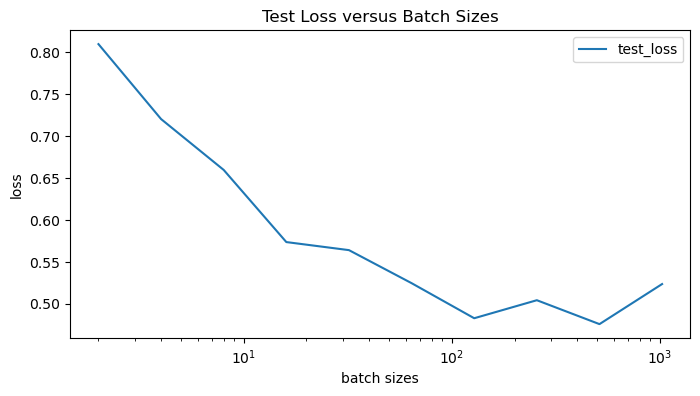

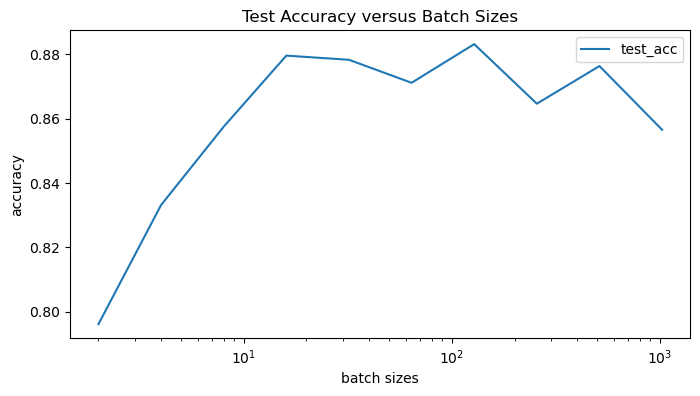

In [ ]:
# plot the loss of testing versus different batch sizes
plt.figure(figsize=(8, 4))
plt.semilogx(size_list, test_loss_list_bs, label='test_loss')  
plt.legend()  
plt.title('Test Loss versus Batch Sizes')
plt.xlabel('batch sizes')
plt.ylabel('loss')

# plot the accuracy of testing versus different batch sizes
plt.figure(figsize=(8, 4))
plt.semilogx(size_list, test_acc_list_bs, label='test_acc')  
plt.legend()
plt.title('Test Accuracy versus Batch Sizes')
plt.xlabel('batch sizes')
plt.ylabel('accuracy')

plt.show()

#### Loss and Accuracy vs Embedding Dimensions

In [35]:
# initialize a loss list and an accuracy list
test_loss_list_em = list(); test_acc_list_em = list()

# initialize the minimum and the maximum of embedding dimensions
# as well as a step
min_dim = 10; max_dim = 100; step = 10

# generate a list of dimensions with equal interval 
em_dims = list(range(min_dim, max_dim + 1, step))

In [36]:
# train the BiLSTM model with different learning rates 
# and record testing loss and accuracy
for dim in em_dims:
    keras.backend.clear_session()
    
    model = BiLSTM(num_words, dim, maxlen, num_hidden_layers, dropout, num_outputs)
    
    _, _, _, _, loss_test_em, acc_test_em = train(model, text_vec_test, labels_test, 
                                                  text_vec_train, labels_train, 
                                                  learning_rate, epochs, batch_size, 
                                                  valid_split, b1, b2)
    
    test_loss_list_em.append(loss_test_em)
    test_acc_list_em.append(acc_test_em)

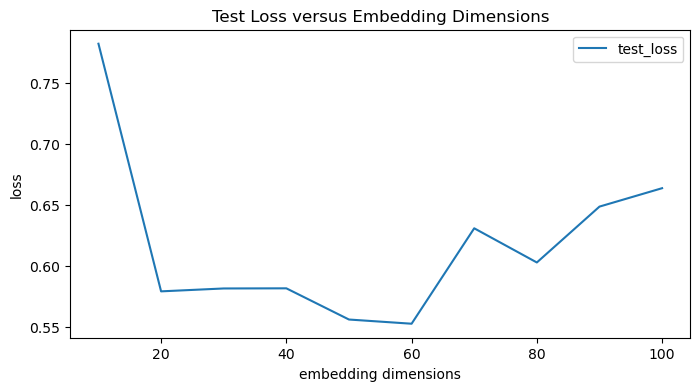

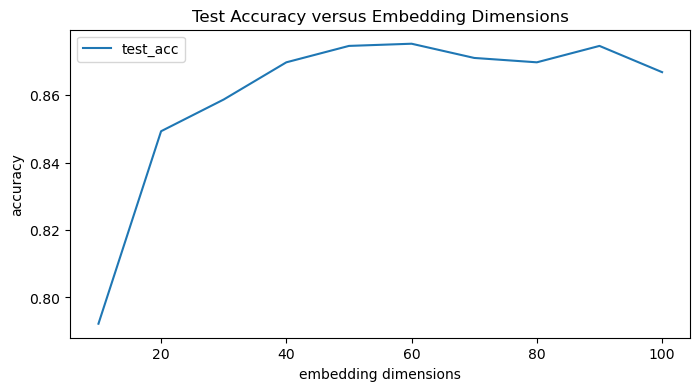

In [ ]:
# plot the loss of testing versus different embedding dimensions
plt.figure(figsize=(8, 4))
plt.plot(em_dims, test_loss_list_em, label='test_loss')  
plt.legend()  
plt.title('Test Loss versus Embedding Dimensions')
plt.xlabel('embedding dimensions')
plt.ylabel('loss')

# plot the accuracy of testing versus embedding dimensions
plt.figure(figsize=(8, 4))
plt.plot(em_dims, test_acc_list_em, label='test_acc')  
plt.legend()
plt.title('Test Accuracy versus Embedding Dimensions')
plt.xlabel('embedding dimensions')
plt.ylabel('accuracy')

plt.show()

# Overall Result

In [38]:
# Download save trained models, commnet out this cell for full train
if not os.path.exists("models"):
    !gdown --id 19jF_9EZxD9LaBNEyaq2XKfoNmOFh8LtO
    with zipfile.ZipFile('models.zip', 'r') as zip_ref:
        zip_ref.extractall('models')
    clear_output()

In [39]:
datasets = ['banking77', '10newsgroup', 'ag_news']

In [40]:
results = np.zeros((4, len(datasets)*3))

In [41]:
# train with modifying preprocess across all datasets, using saved models to get faster result
save_dir = "models"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
for n, dataset in enumerate(datasets):
    for preprocess_option in range(4):
        # print progress
        print(results.round(4))
        print("Processing", dataset, f"with preprocess #{preprocess_option}")
        
        # preprocessing
        train_dataset, test_dataset = load_dataset(dataset)
        if preprocess_option!=0:
            train_dataset['text'] = train_dataset.text.apply(lambda x: preprocess_text(x, opt=preprocess_option))
            test_dataset['text'] = test_dataset.text.apply(lambda x: preprocess_text(x, opt=preprocess_option))
            min_word_freq = 3
            print("Preprocess Done")
        else:
            min_word_freq = -1
            
        # SVM
        print("Processing SVM")
        clf = SVM(train_dataset)
        
        if True: #dataset=='ag_news':
            clf = SVM(train_dataset, ['rbf'], [10], [1])
        
        save_path = os.path.join(save_dir, dataset+"_opt"+str(preprocess_option)+".joblib")
        if os.path.exists(save_path):
            clf.clf = load(save_path)
        else:
            clf.train()
            dump(clf.clf, save_path)

        results[preprocess_option, 3*n] = clf.test(test_dataset)
        
        # CNN
        print("Processing CNN")
        train_loader, valid_loader, test_loader = preprocessCNN(train_dataset, test_dataset, min_word_freq=min_word_freq)
        params = {
            'num_kernels': 100,
            'kernel_size': [2, 3, 4],
            'num_class': len(train_dataset.label.unique()),
            'stride': 1,
            'pretrained_weight': False,
            #input size
            'vocab_size': len(dict_words),
            'embedding_dim': 300,
            'dropout': 0.5
        }
        model = CNNClassifier(params)
        model.to(device)
        save_path = os.path.join(save_dir, dataset+"_opt"+str(preprocess_option)+".pth")
        if os.path.exists(save_path):
            print("Save found")
            model.load_state_dict(torch.load(save_path))
        else:
            train_cnn(best_model_path=save_path)
        results[preprocess_option, 3*n+1] = test_cnn()
        
        # RNN
        print("Processing RNN")
        save_path = os.path.join(save_dir, dataset+"_opt"+str(preprocess_option)+".h5")
        init_rnn(save_path, min_word_freq=min_word_freq, skip_encode=True)
        if not os.path.exists(save_path):
            result = model.fit(text_vec_train, train_dataset.label, 
                    epochs=20, 
                    batch_size=32,
                    validation_split=0.15,
                    callbacks=[checkpoint, early_stopping])
        else:
            print("Save found")
        results[preprocess_option, 3*n+2] = test_rnn(save_path)
        
        clear_output()

In [43]:
# Define the MultiIndex for columns
columns_multiindex = pd.MultiIndex.from_product([datasets, ['SVM', 'CNN', 'RNN']], names=['Dataset', 'ML Model'])

# Create DataFrame
df = pd.DataFrame(results.T.round(4)*100, index=columns_multiindex)

# Print DataFrame
df

0      1      2      3
Dataset     ML Model                            
banking77   SVM       90.39  89.90  90.32  87.05
            CNN       82.60  86.20  88.08  82.76
            RNN       85.75  86.69  87.40  85.49
10newsgroup SVM       97.50  97.00  98.00  96.00
            CNN       78.00  88.50  88.50  91.00
            RNN       38.00  35.50  56.50  66.50
ag_news     SVM       92.22  91.49  92.17  91.97
            CNN       90.11  90.42  90.67  90.79
            RNN       91.86  91.66  91.92  91.70